<a href="https://colab.research.google.com/github/YogitaChaudhari52/Malaria-Detection-Using-Maching-Learning/blob/main/Final_Work_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Malaria Detection using machine learning

In [ ]:
3mport numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.applications.vgg19 import VGG19
from keras.layers import Dense,Conv2D,MaxPool2D,Flatten
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
import cv2

In [ ]:
!git clone https://github.com/YogitaChaudhari52/Malaria-Detection-Using-Maching-Learning.git

Cloning into 'Malaria-Detection-Using-Maching-Learning'...
remote: Enumerating objects: 27607, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 27607 (delta 2), reused 37 (delta 1), pack-reused 27569
Receiving objects: 100% (27607/27607), 332.66 MiB | 20.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (27562/27562), done.


In [ ]:
# using ImageDataGenerator to rescale all images and spliiting with 80% train and 20% validation
data = ImageDataGenerator(rescale=1/255.0, validation_split=0.3)
width=64
height=64

In [ ]:
train_set=data.flow_from_directory(directory='/content/Malaria-Detection-Using-Maching-Learning/cell_images',                           
                                   target_size=(width,height),
                                    class_mode='binary',
                                    batch_size=16,
                                    subset='training')

Found 19292 images belonging to 2 classes.


In [ ]:
# test_set with same features but subset='validation'
test_set=data.flow_from_directory(directory='/content/Malaria-Detection-Using-Maching-Learning/cell_images',
                                   target_size=(224,224),
                                    class_mode='binary',
                                    batch_size=16,
                                    subset='validation'
                                   )

Found 8266 images belonging to 2 classes.


VGG Model

In [ ]:
 weights initialisation from imagenet nad top layer is not included since we have our own categories
vgg19=VGG19(input_shape=[224,224,3],weights='imagenet',include_top=False)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
# we don't want to train the vgg19 model layers again
for layer in vgg19.layers:
    layer.trainable=False

In [ ]:
# adding our own flatten layer
x=Flatten()(vgg19.output)
# creating a prediction dense layer with activation of softmax after x layer created above
prediction=Dense(2,activation='softmax')(x)
# model is created with inputs from vgg19 and outputs as our prediction layer
model=Model(inputs=vgg19.input,outputs=prediction)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# compiling of our customized model
model.compile(
  loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
# fitting our training data and saving results in history 
history = model.fit_generator(generator = train_set,
                              validation_data = test_set,
                              epochs =2)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/2


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4930: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


  12/1206 [..............................] - ETA: 3:17:24 - loss: 2.5557 - accuracy: 0.3778

KeyboardInterrupt: ignored

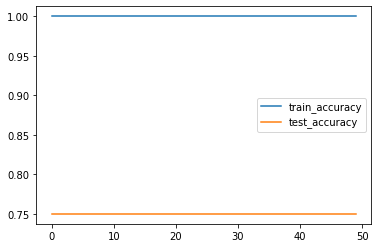

In [ ]:
plt.plot(history.history['accuracy'],label='train_accuracy')
plt.plot(history.history['val_accuracy'],label='test_accuracy')
plt.legend()
plt.show()

In [ ]:
# saving our model in a .h5 file
from tensorflow.keras.models import load_model
model.save('malaria_vgg19.h5')

In [ ]:
y_pred=model.predict(test_set)
y_pred[:10]

array([[0.01159297, 0.98840696],
       [0.03841059, 0.9615894 ],
       [0.9583917 , 0.04160834],
       [0.28256154, 0.71743846]], dtype=float32)

In [ ]:
predictions=np.argmax(y_pred,axis=1)
predictions[:10]

array([1, 1, 0, 1])

Resnet

In [ ]:
from fastai.vision import *
from fastai.metrics import error_rate
from fastai.callbacks import SaveModelCallback
# Imports for diverse utilities
from shutil import copyfile
import matplotlib.pyplot as plt
import operator
from PIL import Image
from sys import intern   # For the symbol definitions

In [ ]:
# Export network for deployment and create a copy
def exportStageTo(learn, path):
    learn.export()
    # Faça backup diferenciado
    copyfile(path/'export.pkl', path/'export-malaria.pkl')

In [ ]:
# Restoration of a deployment model, for example in order to continue fine-tuning
def restoreStageFrom(path):
  # Restore a backup
  copyfile(path/'export-malaria.pkl', path/'export.pkl')
  return load_learner(path)

In [ ]:
!apt install tree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  tree
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 40.7 kB of archives.
After this operation, 105 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 tree amd64 1.7.0-5 [40.7 kB]
Fetched 40.7 kB in 0s (142 kB/s)
Selecting previously unselected package tree.
(Reading database ... 160837 files and directories currently installed.)
Preparing to unpack .../tree_1.7.0-5_amd64.deb ...
Unpacking tree (1.7.0-5) ...
Setting up tree (1.7.0-5) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [ ]:
!mv /content/Malaria-Detection-Using-Maching-Learning/cell_images train
!mkdir data
!mv train data

In [ ]:
!tree ./data --dirsfirst --filelimit 10

./data
└── train
    ├── Parasitized [13780 entries exceeds filelimit, not opening dir]
    └── Uninfected [13780 entries exceeds filelimit, not opening dir]

3 directories, 0 files


In [ ]:
bs = 256                # Batch size, 256 for small images on a T4 GPU...
size = 128              # Image size, 128x128 is a bit smaller than most of the images...
path = Path("./content/data")   # The path to the 'train' folder you created...

In [ ]:
tfms = get_transforms(max_rotate=None, max_warp=None, max_zoom=1.0)
# Create the DataBunch!
# Remember that you'll have images that are bigger than 128x128 and images that are smaller,   
# so squish them all in order to occupy exactly 128x128 pixels...
path="/content/data/train"
data = ImageDataBunch.from_folder(path, ds_tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH, 
                                  valid_pct = 0.2, bs=bs)
#
print('Transforms = ', len(tfms))
# Save the DataBunch in case the training goes south... so you won't have to regenerate it..
# Remember: this DataBunch is tied to the batch size you selected. 
data.save('imageDataBunch-bs-'+str(bs)+'-size-'+str(size)+'.pkl')
# Show the statistics of the Bunch...
print(data.classes)
data

Transforms =  2
['Parasitized', 'Uninfected']


ImageDataBunch;

Train: LabelList (22047 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Uninfected,Uninfected,Uninfected,Uninfected,Uninfected
Path: /content/data/train;

Valid: LabelList (5511 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
Parasitized,Parasitized,Uninfected,Uninfected,Parasitized
Path: /content/data/train;

Test: None

In [ ]:
learn18 = cnn_learner(data, models.resnet18, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
import torch

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" 

In [ ]:
#to /root/.torch/models/resnet18-5c106cde.pth
#46827520it [00:01, 28999302.58it/s]


import torch 
import torchvision
import os

# Suppose you are trying to load pre-trained resnet model in directory- models\resnet

os.environ['TORCH_HOME'] = '/root/.torch/models/resnet18-5c106cde.pth 46827520it [00:01, 28999302.58it/s' #setting the environment variable
resnet = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.torch/models/resnet18-5c106cde.pth 46827520it [00:01, 28999302.58it/s/hub/checkpoints/resnet18-f37072fd.pth


In [ ]:
learn18.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
learn18.fit_one_cycle(1, callbacks=[SaveModelCallback(learn18, every='epoch', monitor='accuracy', name='malaria18-1')])
# Save the model
learn18.save('malaria18-stage-1')
# export the model stage
exportStageTo(learn18, path)

epoch,train_loss,valid_loss,error_rate,time


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3658: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale

KeyboardInterrupt: ignored